In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
import time
from sklearn.metrics import explained_variance_score

In [2]:
class AP_GRU_Lag(nn.Module):
    def __init__(self, H_no, lag, device):
        super().__init__()
        
        self.H_no = H_no
        self.device = device
        
        self.rnn = nn.GRU(lag+1, H_no, batch_first=True)
        self.linear = nn.Linear(H_no, 1)
        self.step = Step.apply
        
    def forward(self, V, temp):
        #V is shape (batch, 50000, lag+1)

        rnn_out, _ = self.rnn(V) #(batch,50000,H)
        rnn_out = rnn_out.reshape(-1,self.H_no)
        lin_out = self.linear(rnn_out) #(batch*50000,1)
        #final = torch.sigmoid(lin_out.reshape(V.shape[0], V.shape[1]))
        final = self.step(lin_out.reshape(V.shape[0], V.shape[1]) / temp)
        
        return final

class Step(torch.autograd.Function):

    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return torch.heaviside(input, torch.ones_like(input))

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        return grad_input * torch.sigmoid(input) * (1 - torch.sigmoid(input))

In [3]:
batch_size = 20
batch_length = int(50000 / 5 / 0.2)
H_no = 40
device = torch.device("cuda")
lag = 20

epoch_no = 400
iter_no = epoch_no * 980 // batch_size

V = np.load("/media/hdd01/sklee/CA1_clust4-60/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy").reshape(-1,50001)[:,:50000]
#V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/V_diff_stimseed1.npy").reshape(-1,batch_length)
#V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/comb_pred/V_comb_pred_0.2ms.npy").reshape(-1,batch_length)
#V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/diff_true/V_diff_true_0.2ms.npy").reshape(-1,batch_length)
S = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/spike_train_0.2ms.npy").reshape(-1,batch_length)

V-= np.mean(V)

V = torch.from_numpy(V)
S = torch.from_numpy(S)

V_lag = np.zeros((V.shape[0], V.shape[1], lag)) #(lag,1000,50000)
for i in range(lag):
    V_lag[:,i+1:,i] = V[:,:-i-1]

V_lag = torch.from_numpy(V_lag)
print(V_lag.shape)

torch.Size([1000, 50000, 20])


In [4]:
V_train = V[:980].float()
V_test = V[980:].float().to(device)
S_train = S[:980].float()
S_test = S[980:].float().to(device)
V_lag_train = V_lag[:980].float()
V_lag_test = V_lag[980:].float().to(device)

train_idx = np.empty((epoch_no, 980))
for i in range(epoch_no):
    part_idx = np.arange(0,980,1)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.reshape(-1, batch_size)
train_idx = torch.from_numpy(train_idx).long()
print(train_idx.shape)

torch.Size([19600, 20])


In [5]:
model = AP_GRU_Lag(H_no, lag, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

bce_criterion = nn.BCELoss(reduction="mean")

7601


In [6]:
score_list = []
temp_list = np.logspace(0,-4,100)

spk_kern = torch.exp(-0.05*torch.arange(100).to(device))

for i in tnrange(iter_no):
#for i in tnrange(10000):    
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    temp = torch.tensor(temp_list[i//50])
    
    batch_idx = train_idx[i]
    batch_S = S_train[batch_idx].to(device)
    batch_V = V_train[batch_idx].to(device)
    batch_V_lag = V_lag_train[batch_idx].to(device)
    
    batch_V_in = torch.zeros(batch_size, batch_length, lag+1).to(device)
    batch_V_in[:,:,0] = batch_V
    batch_V_in[:,:,1:] = batch_V_lag
    
    S_out = model(batch_V_in, temp)
    #loss = bce_criterion(S_out, batch_S)
    
    S_pad_out = torch.zeros(S_out.shape[0], S_out.shape[1]+99).to(device)
    S_pad_out[:,99:] = S_pad_out[:,99:] + S_out
    S_conv_out = F.conv1d(S_pad_out.unsqueeze(1), spk_kern.reshape(1,1,-1)).squeeze(1)
    
    batch_S_pad = torch.zeros(batch_S.shape[0], batch_S.shape[1]+99).to(device)
    batch_S_pad[:,99:] = batch_S_pad[:,99:] + batch_S
    batch_S_conv = F.conv1d(batch_S_pad.unsqueeze(1), spk_kern.reshape(1,1,-1)).squeeze(1)
    
    loss = torch.mean((S_conv_out - batch_S_conv) ** 2)
    
    
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 10)
    optimizer.step()
    
    step_time = time.time() - s
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        V_test_in = torch.zeros(batch_size, batch_length, lag+1).to(device)
        V_test_in[:,:,0] = V_test
        V_test_in[:,:,1:] = V_lag_test
        
        test_S_out = model(V_test_in, 1)
        #test_loss = bce_criterion(test_S_out, S_test).item()
        
        #score_list.append(test_loss)
        
        test_S_pad_out = torch.zeros(test_S_out.shape[0], test_S_out.shape[1]+99).to(device)
        test_S_pad_out[:,99:] = test_S_pad_out[:,99:] + test_S_out
        test_S_conv_out = F.conv1d(test_S_pad_out.unsqueeze(1), spk_kern.reshape(1,1,-1)).squeeze(1)

        test_S_pad = torch.zeros(S_test.shape[0], S_test.shape[1]+99).to(device)
        test_S_pad[:,99:] = test_S_pad[:,99:] + S_test
        test_S_conv = F.conv1d(test_S_pad.unsqueeze(1), spk_kern.reshape(1,1,-1)).squeeze(1)
        
        test_loss = torch.mean((test_S_conv_out - test_S_conv) ** 2)
        
        print(i, test_loss.item(), torch.sum(test_S_out).item())
        
        #tp = np.where((test_S_out.cpu().detach().numpy() == 1) & (S_test.cpu().detach().numpy() == 1))[0].size
        #fp = np.where((test_S_out.cpu().detach().numpy() == 1) & (S_test.cpu().detach().numpy() == 0))[0].size
        #tn = np.where((test_S_out.cpu().detach().numpy() == 0) & (S_test.cpu().detach().numpy() == 0))[0].size
        #fn = np.where((test_S_out.cpu().detach().numpy() == 0) & (S_test.cpu().detach().numpy() == 1))[0].size
        
        #print("TP",tp,"FP",fp,"TN",tn,"FN",fn)
        #print("-----------------------")

<ipython-input-6-ed3c07dad700>:6: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


  0%|          | 0/19600 [00:00<?, ?it/s]

0 172.4680938720703 444848.0
49 0.02678292989730835 325.0
99 0.013709913939237595 241.0
149 0.008002351969480515 143.0
199 0.010893306694924831 218.0
249 0.009215922094881535 182.0
299 0.009839816950261593 200.0
349 0.011724142357707024 233.0
399 0.008984465152025223 176.0
449 0.011714343912899494 231.0
499 0.00910535454750061 185.0
549 0.008435155265033245 182.0
599 0.0021646323148161173 8.0
649 0.002080569276586175 0.0
699 0.0032077431678771973 47.0
749 0.0080414405092597 178.0
799 0.002080569276586175 0.0
849 0.21396856009960175 2636.0
899 0.002080569276586175 0.0
949 0.002080569276586175 0.0
999 0.002080569276586175 0.0
1049 0.002080569276586175 0.0
1099 0.00966140627861023 213.0
1149 0.0021223900839686394 6.0
1199 0.002075508702546358 1.0
1249 0.002508820965886116 21.0
1299 0.002080569276586175 0.0
1349 0.002080569276586175 0.0
1399 0.049493320286273956 857.0
1449 0.5295156240463257 4414.0
1499 0.002367135137319565 14.0
1549 0.01958620920777321 410.0
1599 0.018482664600014687 447.

KeyboardInterrupt: 

In [7]:
print(torch.mean((test_S_conv - torch.zeros_like(S_test)) ** 2))

tensor(0.0021, device='cuda:0')


(0.0, 0.1)

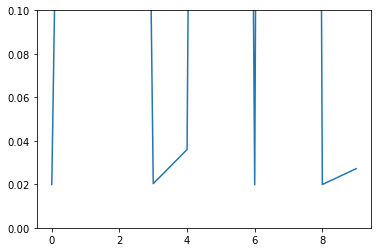

In [8]:
plt.plot(np.asarray(score_list)[20:])
plt.ylim(0,0.1)

tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)


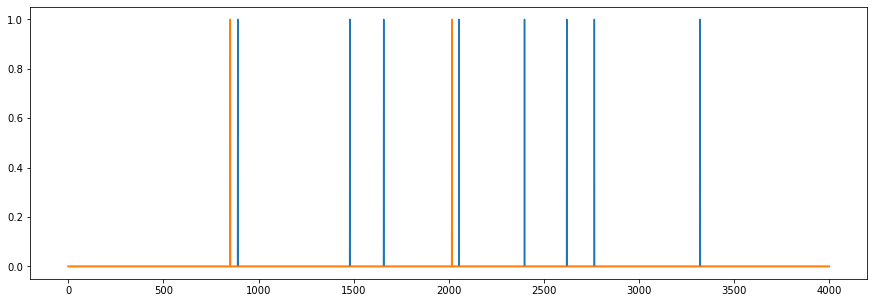

In [13]:
plt.figure(figsize = (15,5))
plt.plot(S_test[2].cpu().detach().numpy()[23000:27000])
plt.plot(test_S_out[2].cpu().detach().numpy()[23000:27000])
#plt.xlim(4500,5200)
#plt.ylim(-1,10)
print(torch.max(test_S_out))

In [18]:
prec_rec = np.empty((20,2))

for i in range(20):
    tp = np.where((test_S_out[i].cpu().detach().numpy() == 1) & (S_test[i].cpu().detach().numpy() == 1))[0].size
    fp = np.where((test_S_out[i].cpu().detach().numpy() == 1) & (S_test[i].cpu().detach().numpy() == 0))[0].size
    tn = np.where((test_S_out[i].cpu().detach().numpy() == 0) & (S_test[i].cpu().detach().numpy() == 0))[0].size
    fn = np.where((test_S_out[i].cpu().detach().numpy() == 0) & (S_test[i].cpu().detach().numpy() == 1))[0].size
    
    prec_rec[i,0] = tp / (tp + fp)
    prec_rec[i,1] = tp / (tp + fn)
    
tp = np.where((test_S_out.cpu().detach().numpy() == 1) & (S_test.cpu().detach().numpy() == 1))[0].size
fp = np.where((test_S_out.cpu().detach().numpy() == 1) & (S_test.cpu().detach().numpy() == 0))[0].size
tn = np.where((test_S_out.cpu().detach().numpy() == 0) & (S_test.cpu().detach().numpy() == 0))[0].size
fn = np.where((test_S_out.cpu().detach().numpy() == 0) & (S_test.cpu().detach().numpy() == 1))[0].size

prec = tp / (tp + fp)
rec = tp / (tp + fn)
print(rec, prec)

0.7171717171717171 0.9861111111111112


In [9]:
#torch.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust4-60_AP/na_true_0.1noise1/gru_l20_h40_0.2ms.pt")
#np.save("/media/hdd01/sklee/CA1_clust4-60_AP/na_true_0.1noise1/gru_l20_h40_0.2ms_test.npy", test_S_out.cpu().detach().numpy())

In [7]:
#np.save("/media/hdd01/sklee/CA1_clust4-60_AP/comb_pred/gru_determ_l20_h40_0.2ms_test.npy", test_S_out.cpu().detach().numpy())